In [ ]:
import pickle

import tensorflow.keras.models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, TimeDistributed, Bidirectional

import pickle

import numpy as np
from numpy import random

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-me2tx1aw
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-me2tx1aw
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=0e27d10168277c52eaf46ac941a9d5af252a27aa08530e7066818cfc0d012c6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-wye0bhqv/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from __future__ import absolute_import
from __future__ import division

import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.layers import Layer
from keras.layers import InputSpec

from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_marginal_accuracy
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.utils.test_utils import to_tuple


class CRF(Layer):
    """An implementation of linear chain conditional random field (CRF).
    An linear chain CRF is defined to maximize the following likelihood function:
    $$ L(W, U, b; y_1, ..., y_n) := \frac{1}{Z}
    \sum_{y_1, ..., y_n} \exp(-a_1' y_1 - a_n' y_n
        - \sum_{k=1^n}((f(x_k' W + b) y_k) + y_1' U y_2)), $$
    where:
        $Z$: normalization constant
        $x_k, y_k$:  inputs and outputs
    This implementation has two modes for optimization:
    1. (`join mode`) optimized by maximizing join likelihood,
    which is optimal in theory of statistics.
       Note that in this case, CRF must be the output/last layer.
    2. (`marginal mode`) return marginal probabilities on each time
    step and optimized via composition
       likelihood (product of marginal likelihood), i.e.,
       using `categorical_crossentropy` loss.
       Note that in this case, CRF can be either the last layer or an
       intermediate layer (though not explored).
    For prediction (test phrase), one can choose either Viterbi
    best path (class indices) or marginal
    probabilities if probabilities are needed.
    However, if one chooses *join mode* for training,
    Viterbi output is typically better than marginal output,
    but the marginal output will still perform
    reasonably close, while if *marginal mode* is used for training,
    marginal output usually performs
    much better. The default behavior and `metrics.crf_accuracy`
    is set according to this observation.
    In addition, this implementation supports masking and accepts either
    onehot or sparse target.
    If you open a issue or a pull request about CRF, please
    add 'cc @lzfelix' to notify Luiz Felix.
    # Examples
    ```python
        from keras_contrib.layers import CRF
        from keras_contrib.losses import crf_loss
        from keras_contrib.metrics import crf_viterbi_accuracy
        model = Sequential()
        model.add(Embedding(3001, 300, mask_zero=True)(X)
        # use learn_mode = 'join', test_mode = 'viterbi',
        # sparse_target = True (label indice output)
        crf = CRF(10, sparse_target=True)
        model.add(crf)
        # crf_accuracy is default to Viterbi acc if using join-mode (default).
        # One can add crf.marginal_acc if interested, but may slow down learning
        model.compile('adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
        # y must be label indices (with shape 1 at dim 3) here,
        # since `sparse_target=True`
        model.fit(x, y)
        # prediction give onehot representation of Viterbi best path
        y_hat = model.predict(x_test)
    ```
    The following snippet shows how to load a persisted
    model that uses the CRF layer:
    ```python
        from keras.models import load_model
        from keras_contrib.losses import import crf_loss
        from keras_contrib.metrics import crf_viterbi_accuracy
        custom_objects={'CRF': CRF,
                        'crf_loss': crf_loss,
                        'crf_viterbi_accuracy': crf_viterbi_accuracy}
        loaded_model = load_model('<path_to_model>',
                                  custom_objects=custom_objects)
    ```
    # Arguments
        units: Positive integer, dimensionality of the output space.
        learn_mode: Either 'join' or 'marginal'.
            The former train the model by maximizing join likelihood while the latter
            maximize the product of marginal likelihood over all time steps.
            One should use `losses.crf_nll` for 'join' mode
            and `losses.categorical_crossentropy` or
            `losses.sparse_categorical_crossentropy` for
            `marginal` mode.  For convenience, simply
            use `losses.crf_loss`, which will decide the proper loss as described.
        test_mode: Either 'viterbi' or 'marginal'.
            The former is recommended and as default when `learn_mode = 'join'` and
            gives one-hot representation of the best path at test (prediction) time,
            while the latter is recommended and chosen as default
            when `learn_mode = 'marginal'`,
            which produces marginal probabilities for each time step.
            For evaluating metrics, one should
            use `metrics.crf_viterbi_accuracy` for 'viterbi' mode and
            'metrics.crf_marginal_accuracy' for 'marginal' mode, or
            simply use `metrics.crf_accuracy` for
            both which automatically decides it as described.
            One can also use both for evaluation at training.
        sparse_target: Boolean (default False) indicating
            if provided labels are one-hot or
            indices (with shape 1 at dim 3).
        use_boundary: Boolean (default True) indicating if trainable
            start-end chain energies
            should be added to model.
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        chain_initializer: Initializer for the `chain_kernel` weights matrix,
            used for the CRF chain energy.
            (see [initializers](../initializers.md)).
        boundary_initializer: Initializer for the `left_boundary`,
            'right_boundary' weights vectors,
            used for the start/left and end/right boundary energy.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        chain_regularizer: Regularizer function applied to
            the `chain_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        boundary_regularizer: Regularizer function applied to
            the 'left_boundary', 'right_boundary' weight vectors
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        chain_constraint: Constraint function applied to
            the `chain_kernel` weights matrix
            (see [constraints](../constraints.md)).
        boundary_constraint: Constraint function applied to
            the `left_boundary`, `right_boundary` weights vectors
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        unroll: Boolean (default False). If True, the network will be
            unrolled, else a symbolic loop will be used.
            Unrolling can speed-up a RNN, although it tends
            to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    # Input shape
        3D tensor with shape `(nb_samples, timesteps, input_dim)`.
    # Output shape
        3D tensor with shape `(nb_samples, timesteps, units)`.
    # Masking
        This layer supports masking for input data with a variable number
        of timesteps. To introduce masks to your data,
        use an [Embedding](embeddings.md) layer with the `mask_zero` parameter
        set to `True`.
    """

    def __init__(self, units,
                 learn_mode='join',
                 test_mode=None,
                 sparse_target=False,
                 use_boundary=True,
                 use_bias=True,
                 activation='linear',
                 kernel_initializer='glorot_uniform',
                 chain_initializer='orthogonal',
                 bias_initializer='zeros',
                 boundary_initializer='zeros',
                 kernel_regularizer=None,
                 chain_regularizer=None,
                 boundary_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 chain_constraint=None,
                 boundary_constraint=None,
                 bias_constraint=None,
                 input_dim=None,
                 unroll=False,
                 **kwargs):
        super(CRF, self).__init__(**kwargs)
        self.supports_masking = True
        self.units = units
        self.learn_mode = learn_mode
        assert self.learn_mode in ['join', 'marginal']
        self.test_mode = test_mode
        if self.test_mode is None:
            self.test_mode = 'viterbi' if self.learn_mode == 'join' else 'marginal'
        else:
            assert self.test_mode in ['viterbi', 'marginal']
        self.sparse_target = sparse_target
        self.use_boundary = use_boundary
        self.use_bias = use_bias

        self.activation = activations.get(activation)

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.chain_initializer = initializers.get(chain_initializer)
        self.boundary_initializer = initializers.get(boundary_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.chain_regularizer = regularizers.get(chain_regularizer)
        self.boundary_regularizer = regularizers.get(boundary_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.chain_constraint = constraints.get(chain_constraint)
        self.boundary_constraint = constraints.get(boundary_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.unroll = unroll

    def build(self, input_shape):
        input_shape = to_tuple(input_shape)
        self.input_spec = [InputSpec(shape=input_shape)]
        self.input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(self.input_dim, self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.chain_kernel = self.add_weight(shape=(self.units, self.units),
                                            name='chain_kernel',
                                            initializer=self.chain_initializer,
                                            regularizer=self.chain_regularizer,
                                            constraint=self.chain_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = 0

        if self.use_boundary:
            self.left_boundary = self.add_weight(shape=(self.units,),
                                                 name='left_boundary',
                                                 initializer=self.boundary_initializer,
                                                 regularizer=self.boundary_regularizer,
                                                 constraint=self.boundary_constraint)
            self.right_boundary = self.add_weight(shape=(self.units,),
                                                  name='right_boundary',
                                                  initializer=self.boundary_initializer,
                                                  regularizer=self.boundary_regularizer,
                                                  constraint=self.boundary_constraint)
        self.built = True

    def call(self, X, mask=None):
        if mask is not None:
            assert K.ndim(mask) == 2, 'Input mask to CRF must have dim 2 if not None'

        if self.test_mode == 'viterbi':
            test_output = self.viterbi_decoding(X, mask)
        else:
            test_output = self.get_marginal_prob(X, mask)

        self.uses_learning_phase = True
        if self.learn_mode == 'join':
            train_output = K.zeros_like(K.dot(X, self.kernel))
            out = K.in_train_phase(train_output, test_output)
        else:
            if self.test_mode == 'viterbi':
                train_output = self.get_marginal_prob(X, mask)
                out = K.in_train_phase(train_output, test_output)
            else:
                out = test_output
        return out

    def compute_output_shape(self, input_shape):
        return input_shape[:2] + (self.units,)

    def compute_mask(self, input, mask=None):
        if mask is not None and self.learn_mode == 'join':
            return K.any(mask, axis=1)
        return mask

    def get_config(self):
        config = {
            'units': self.units,
            'learn_mode': self.learn_mode,
            'test_mode': self.test_mode,
            'use_boundary': self.use_boundary,
            'use_bias': self.use_bias,
            'sparse_target': self.sparse_target,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'chain_initializer': initializers.serialize(self.chain_initializer),
            'boundary_initializer': initializers.serialize(
                self.boundary_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'activation': activations.serialize(self.activation),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'chain_regularizer': regularizers.serialize(self.chain_regularizer),
            'boundary_regularizer': regularizers.serialize(
                self.boundary_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'chain_constraint': constraints.serialize(self.chain_constraint),
            'boundary_constraint': constraints.serialize(self.boundary_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint),
            'input_dim': self.input_dim,
            'unroll': self.unroll}
        base_config = super(CRF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @property
    def loss_function(self):
        warnings.warn('CRF.loss_function is deprecated '
                      'and it might be removed in the future. Please '
                      'use losses.crf_loss instead.')
        return crf_loss

    @property
    def accuracy(self):
        warnings.warn('CRF.accuracy is deprecated and it '
                      'might be removed in the future. Please '
                      'use metrics.crf_accuracy')
        if self.test_mode == 'viterbi':
            return crf_viterbi_accuracy
        else:
            return crf_marginal_accuracy

    @property
    def viterbi_acc(self):
        warnings.warn('CRF.viterbi_acc is deprecated and it might '
                      'be removed in the future. Please '
                      'use metrics.viterbi_acc instead.')
        return crf_viterbi_accuracy

    @property
    def marginal_acc(self):
        warnings.warn('CRF.moarginal_acc is deprecated and it '
                      'might be removed in the future. Please '
                      'use metrics.marginal_acc instead.')
        return crf_marginal_accuracy

    @staticmethod
    def softmaxNd(x, axis=-1):
        m = K.max(x, axis=axis, keepdims=True)
        exp_x = K.exp(x - m)
        prob_x = exp_x / K.sum(exp_x, axis=axis, keepdims=True)
        return prob_x

    @staticmethod
    def shift_left(x, offset=1):
        assert offset > 0
        return K.concatenate([x[:, offset:], K.zeros_like(x[:, :offset])], axis=1)

    @staticmethod
    def shift_right(x, offset=1):
        assert offset > 0
        return K.concatenate([K.zeros_like(x[:, :offset]), x[:, :-offset]], axis=1)

    def add_boundary_energy(self, energy, mask, start, end):
        start = K.expand_dims(K.expand_dims(start, 0), 0)
        end = K.expand_dims(K.expand_dims(end, 0), 0)
        if mask is None:
            energy = K.concatenate([energy[:, :1, :] + start, energy[:, 1:, :]],
                                   axis=1)
            energy = K.concatenate([energy[:, :-1, :], energy[:, -1:, :] + end],
                                   axis=1)
        else:
            mask = K.expand_dims(K.cast(mask, K.floatx()))
            start_mask = K.cast(K.greater(mask, self.shift_right(mask)), K.floatx())
            end_mask = K.cast(K.greater(self.shift_left(mask), mask), K.floatx())
            energy = energy + start_mask * start
            energy = energy + end_mask * end
        return energy

    def get_log_normalization_constant(self, input_energy, mask, **kwargs):
        """Compute logarithm of the normalization constant Z, where
        Z = sum exp(-E) -> logZ = log sum exp(-E) =: -nlogZ
        """
        # should have logZ[:, i] == logZ[:, j] for any i, j
        logZ = self.recursion(input_energy, mask, return_sequences=False, **kwargs)
        return logZ[:, 0]

    def get_energy(self, y_true, input_energy, mask):
        """Energy = a1' y1 + u1' y1 + y1' U y2 + u2' y2 + y2' U y3 + u3' y3 + an' y3
        """
        input_energy = K.sum(input_energy * y_true, 2)  # (B, T)
        # (B, T-1)
        chain_energy = K.sum(K.dot(y_true[:, :-1, :],
                                   self.chain_kernel) * y_true[:, 1:, :], 2)

        if mask is not None:
            mask = K.cast(mask, K.floatx())
            # (B, T-1), mask[:,:-1]*mask[:,1:] makes it work with any padding
            chain_mask = mask[:, :-1] * mask[:, 1:]
            input_energy = input_energy * mask
            chain_energy = chain_energy * chain_mask
        total_energy = K.sum(input_energy, -1) + K.sum(chain_energy, -1)  # (B, )

        return total_energy

    def get_negative_log_likelihood(self, y_true, X, mask):
        """Compute the loss, i.e., negative log likelihood (normalize by number of time steps)
           likelihood = 1/Z * exp(-E) ->  neg_log_like = - log(1/Z * exp(-E)) = logZ + E
        """
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(input_energy, mask,
                                                    self.left_boundary,
                                                    self.right_boundary)
        energy = self.get_energy(y_true, input_energy, mask)
        logZ = self.get_log_normalization_constant(input_energy, mask,
                                                   input_length=K.int_shape(X)[1])
        nloglik = logZ + energy
        if mask is not None:
            nloglik = nloglik / K.sum(K.cast(mask, K.floatx()), 1)
        else:
            nloglik = nloglik / K.cast(K.shape(X)[1], K.floatx())
        return nloglik

    def step(self, input_energy_t, states, return_logZ=True):
        # not in the following  `prev_target_val` has shape = (B, F)
        # where B = batch_size, F = output feature dim
        # Note: `i` is of float32, due to the behavior of `K.rnn`
        prev_target_val, i, chain_energy = states[:3]
        t = K.cast(i[0, 0], dtype='int32')
        if len(states) > 3:
            if K.backend() == 'theano':
                m = states[3][:, t:(t + 2)]
            else:
                m = tf.slice(states[3], [0, t], [-1, 2])
            input_energy_t = input_energy_t * K.expand_dims(m[:, 0])
            # (1, F, F)*(B, 1, 1) -> (B, F, F)
            chain_energy = chain_energy * K.expand_dims(
                K.expand_dims(m[:, 0] * m[:, 1]))
        if return_logZ:
            # shapes: (1, B, F) + (B, F, 1) -> (B, F, F)
            energy = chain_energy + K.expand_dims(input_energy_t - prev_target_val, 2)
            new_target_val = K.logsumexp(-energy, 1)  # shapes: (B, F)
            return new_target_val, [new_target_val, i + 1]
        else:
            energy = chain_energy + K.expand_dims(input_energy_t + prev_target_val, 2)
            min_energy = K.min(energy, 1)
            # cast for tf-version `K.rnn
            argmin_table = K.cast(K.argmin(energy, 1), K.floatx())
            return argmin_table, [min_energy, i + 1]

    def recursion(self, input_energy, mask=None, go_backwards=False,
                  return_sequences=True, return_logZ=True, input_length=None):
        """Forward (alpha) or backward (beta) recursion
        If `return_logZ = True`, compute the logZ, the normalization constant:
        \[ Z = \sum_{y1, y2, y3} exp(-E) # energy
          = \sum_{y1, y2, y3} exp(-(u1' y1 + y1' W y2 + u2' y2 + y2' W y3 + u3' y3))
          = sum_{y2, y3} (exp(-(u2' y2 + y2' W y3 + u3' y3))
          sum_{y1} exp(-(u1' y1' + y1' W y2))) \]
        Denote:
            \[ S(y2) := sum_{y1} exp(-(u1' y1 + y1' W y2)), \]
            \[ Z = sum_{y2, y3} exp(log S(y2) - (u2' y2 + y2' W y3 + u3' y3)) \]
            \[ logS(y2) = log S(y2) = log_sum_exp(-(u1' y1' + y1' W y2)) \]
        Note that:
              yi's are one-hot vectors
              u1, u3: boundary energies have been merged
        If `return_logZ = False`, compute the Viterbi's best path lookup table.
        """
        chain_energy = self.chain_kernel
        # shape=(1, F, F): F=num of output features. 1st F is for t-1, 2nd F for t
        chain_energy = K.expand_dims(chain_energy, 0)
        # shape=(B, F), dtype=float32
        prev_target_val = K.zeros_like(input_energy[:, 0, :])

        if go_backwards:
            input_energy = K.reverse(input_energy, 1)
            if mask is not None:
                mask = K.reverse(mask, 1)

        initial_states = [prev_target_val, K.zeros_like(prev_target_val[:, :1])]
        constants = [chain_energy]

        if mask is not None:
            mask2 = K.cast(K.concatenate([mask, K.zeros_like(mask[:, :1])], axis=1),
                           K.floatx())
            constants.append(mask2)

        def _step(input_energy_i, states):
            return self.step(input_energy_i, states, return_logZ)

        target_val_last, target_val_seq, _ = K.rnn(_step, input_energy,
                                                   initial_states,
                                                   constants=constants,
                                                   input_length=input_length,
                                                   unroll=self.unroll)

        if return_sequences:
            if go_backwards:
                target_val_seq = K.reverse(target_val_seq, 1)
            return target_val_seq
        else:
            return target_val_last

    def forward_recursion(self, input_energy, **kwargs):
        return self.recursion(input_energy, **kwargs)

    def backward_recursion(self, input_energy, **kwargs):
        return self.recursion(input_energy, go_backwards=True, **kwargs)

    def get_marginal_prob(self, X, mask=None):
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(input_energy, mask,
                                                    self.left_boundary,
                                                    self.right_boundary)
        input_length = K.int_shape(X)[1]
        alpha = self.forward_recursion(input_energy, mask=mask,
                                       input_length=input_length)
        beta = self.backward_recursion(input_energy, mask=mask,
                                       input_length=input_length)
        if mask is not None:
            input_energy = input_energy * K.expand_dims(K.cast(mask, K.floatx()))
        margin = -(self.shift_right(alpha) + input_energy + self.shift_left(beta))
        return self.softmaxNd(margin)

    def viterbi_decoding(self, X, mask=None):
        input_energy = self.activation(K.dot(X, self.kernel) + self.bias)
        if self.use_boundary:
            input_energy = self.add_boundary_energy(
                input_energy, mask, self.left_boundary, self.right_boundary)

        argmin_tables = self.recursion(input_energy, mask, return_logZ=False)
        argmin_tables = K.cast(argmin_tables, 'int32')

        # backward to find best path, `initial_best_idx` can be any,
        # as all elements in the last argmin_table are the same
        argmin_tables = K.reverse(argmin_tables, 1)
        # matrix instead of vector is required by tf `K.rnn`
        initial_best_idx = [K.expand_dims(argmin_tables[:, 0, 0])]
        if K.backend() == 'theano':
            from theano import tensor as T
            initial_best_idx = [T.unbroadcast(initial_best_idx[0], 1)]

        def gather_each_row(params, indices):
            n = K.shape(indices)[0]
            if K.backend() == 'theano':
                from theano import tensor as T
                return params[T.arange(n), indices]
            elif K.backend() == 'tensorflow':
                import tensorflow as tf
                indices = K.transpose(K.stack([tf.range(n), indices]))
                return tf.gather_nd(params, indices)
            else:
                raise NotImplementedError

        def find_path(argmin_table, best_idx):
            next_best_idx = gather_each_row(argmin_table, best_idx[0][:, 0])
            next_best_idx = K.expand_dims(next_best_idx)
            if K.backend() == 'theano':
                from theano import tensor as T
                next_best_idx = T.unbroadcast(next_best_idx, 1)
            return next_best_idx, [next_best_idx]

        _, best_paths, _ = K.rnn(find_path, argmin_tables, initial_best_idx,
                                 input_length=K.int_shape(X)[1], unroll=self.unroll)
        best_paths = K.reverse(best_paths, 1)
        best_paths = K.squeeze(best_paths, 2)

        return K.one_hot(best_paths, self.units)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


[[('tadi', 'KAD'), ('dekat', 'KA'), ('bank', 'KN'), ('tiba', 'KAD'), ('ada', 'KK'), ('pakcik', 'KN'), ('minta', 'KPE'), ('tolong', 'KPE'), ('bawa', 'KK'), ('kan', 'KB'), ('keluar', 'KK'), ('duit', 'KN'), ('dia', 'GN3'), ('tolong', 'KPE'), ('la', 'SL'), ('pakcik', 'KN'), ('itu', 'GT'), ('bila', 'KTY'), ('check', 'FOR'), ('baki', 'KN'), ('dulu', 'KAD-KEP'), ('ada', 'KK'), ('ringgit', 'MW'), ('malaysia', 'MW'), ('saja', 'KPN'), ('dalam', 'KS'), ('bank', 'KN'), ('dia', 'GN3'), ('lepas', 'KH'), ('itu', 'GT'), ('dia', 'GN3'), ('kata', 'KN'), ('boleh', 'KB'), ('tak', 'KNF-KEP'), ('bawa', 'KK'), ('keluar', 'KK'), ('ringgit', 'MW'), ('malaysia', 'MW'), ('and', 'FOR'), ('tried', 'FOR'), ('tapi', 'KH-KEP'), ('tak', 'KNF-KEP'), ('boleh', 'KB'), ('kasihan', 'KK'), ('dekat', 'KA'), ('pakcik', 'KN'), ('itu', 'GT')], [('pengulas', 'KN'), ('pun', 'KPN'), ('macam', 'KN'), ('tak', 'KNF-KEP'), ('tahu', 'KA'), ('apa', 'GDT-KTY'), ('nak', 'KB-KEP'), ('juga', 'KPN'), ('ni', 'GT-KEP')], [('kenapa', 'KTY'), ('

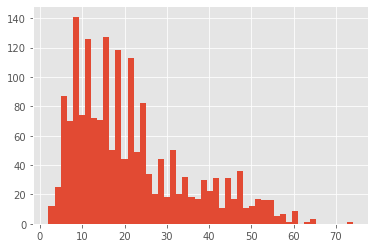

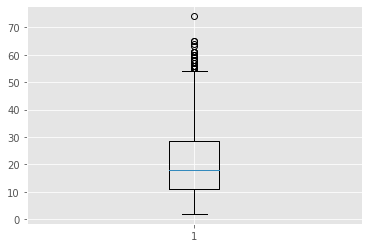

[[3738 5318 3230 ...    0    0    0]
 [3207 2860  405 ...    0    0    0]
 [4808 4163 2964 ...    0    0    0]
 ...
 [1780 3516 2552 ...    0    0    0]
 [4808 4561 5123 ...    0    0    0]
 [4808  530 4631 ...    0    0    0]]
45 5388
[[4592 3924 4617 ...    0    0    0]
 [1738 4963 4485 ...    0    0    0]
 [4884 2316    1 ...    0    0    0]
 ...
 [5131 1702  713 ...    0    0    0]
 [1513 4472 4133 ...    0    0    0]
 [4159  769 4487 ...    0    0    0]]


In [ ]:
copied_path ='/content/gdrive/MyDrive/FYP/TAGGED_Malay_Tweets_Training_Corpus.txt'

import pandas as pd

file=open(copied_path,"rt")
data=[]
contents =file.readlines()
indx=1
for x in contents:
    words=x.split()
    #print(len(words))
    for i in range(len(words)):
      tags=words[i].split("/")
      #print(len(tags))
      data.append([indx,tags[0],tags[1]])
    indx+=1



df=pd.DataFrame(data,columns=['sentence_idx','word','tag'])
df

tag=df['tag'].unique()
tag

vocab=df['word'].unique()
vocab

df['tag'].value_counts()

class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(df)

sentences = getter.sentences

print(sentences)

maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)
#check the max length of a sentence so that we can pad them

# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use("ggplot")

plt.hist([len(s) for s in sentences], bins=50)
plt.show()

plt.boxplot([len(s) for s in sentences])
plt.show()

#Map sentences and POS tags
from future.utils import iteritems

words = list(set(df["word"].values))
number_words = len(words)
tag_path="/content/gdrive/MyDrive/FYP/200521/index_to_tag200521-2.pickle"
word_path="/content/gdrive/MyDrive/FYP/200521/word_to_index200521-2.pickle"

tagfile=open(tag_path,"rb")
idx2tag=pickle.load(tagfile)
tag2idx=dict((v,k)for k,v in idx2tag.items())

wordfile=open(word_path,"rb")
word2idx=pickle.load(wordfile)
idx2word=dict((v,k)for k,v in word2idx.items())

"""##Padding

"""

MAX_LEN=maxlen

#Pad sequence data 
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post")
print(X)

number_words=5388
number_tags=45

print(number_tags,number_words)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post")

#One hot encode 
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=number_tags+1) for i in y]

#Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train)

In [ ]:
#Initialise model 
import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import  crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
import pickle

In [ ]:
model_path="/content/gdrive/MyDrive/FYP/200521/model200521-2.tf"
model2=load_model(model_path,custom_objects={'CRF':CRF,'crf_loss':crf_loss,'crf_viterbi_accuracy':crf_viterbi_accuracy})
model2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 74)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 74, 300)           1616700   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 74, 600)           1442400   
_________________________________________________________________
time_distributed_8 (TimeDist (None, 74, 46)            27646     
_________________________________________________________________
crf_8 (CRF)                  (None, 74, 46)            4370      
Total params: 3,091,116
Trainable params: 1,474,416
Non-trainable params: 1,616,700
_________________________________________________________________


In [ ]:
#Evaluating the model
from sklearn.metrics import classification_report
y_pred = model2.predict(np.array(X_test))  
print(classification_report(np.argmax(y_test, 2).ravel(), 
                            np.argmax(y_pred, axis=2).ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

      GN3-LD       1.00      0.17      0.29        18
      KA-KEP       1.00      1.00      1.00        36
     GDT-KTY       1.00      1.00      1.00       118
        KBIL       1.00      0.91      0.96        47
         KPB       1.00      0.95      0.97        20
         KPN       1.00      1.00      1.00       262
          GT       0.99      1.00      0.99       183
         FOR       0.92      0.89      0.90       651
         KAD       0.97      0.92      0.94       241
         KEP       0.79      0.32      0.46        34
     FOR-NEG       0.00      0.00      0.00         1
      GN2-LD       0.50      0.06      0.11        16
      KN-KEP       1.00      1.00      1.00         2
     KAD-KEP       1.00      1.00      1.00        19
          MW       0.00      0.00      0.00         3
      KH-KEP       1.00      1.00      1.00        42
          BY       0.95      0.74      0.83       128
     FOR-KEP       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

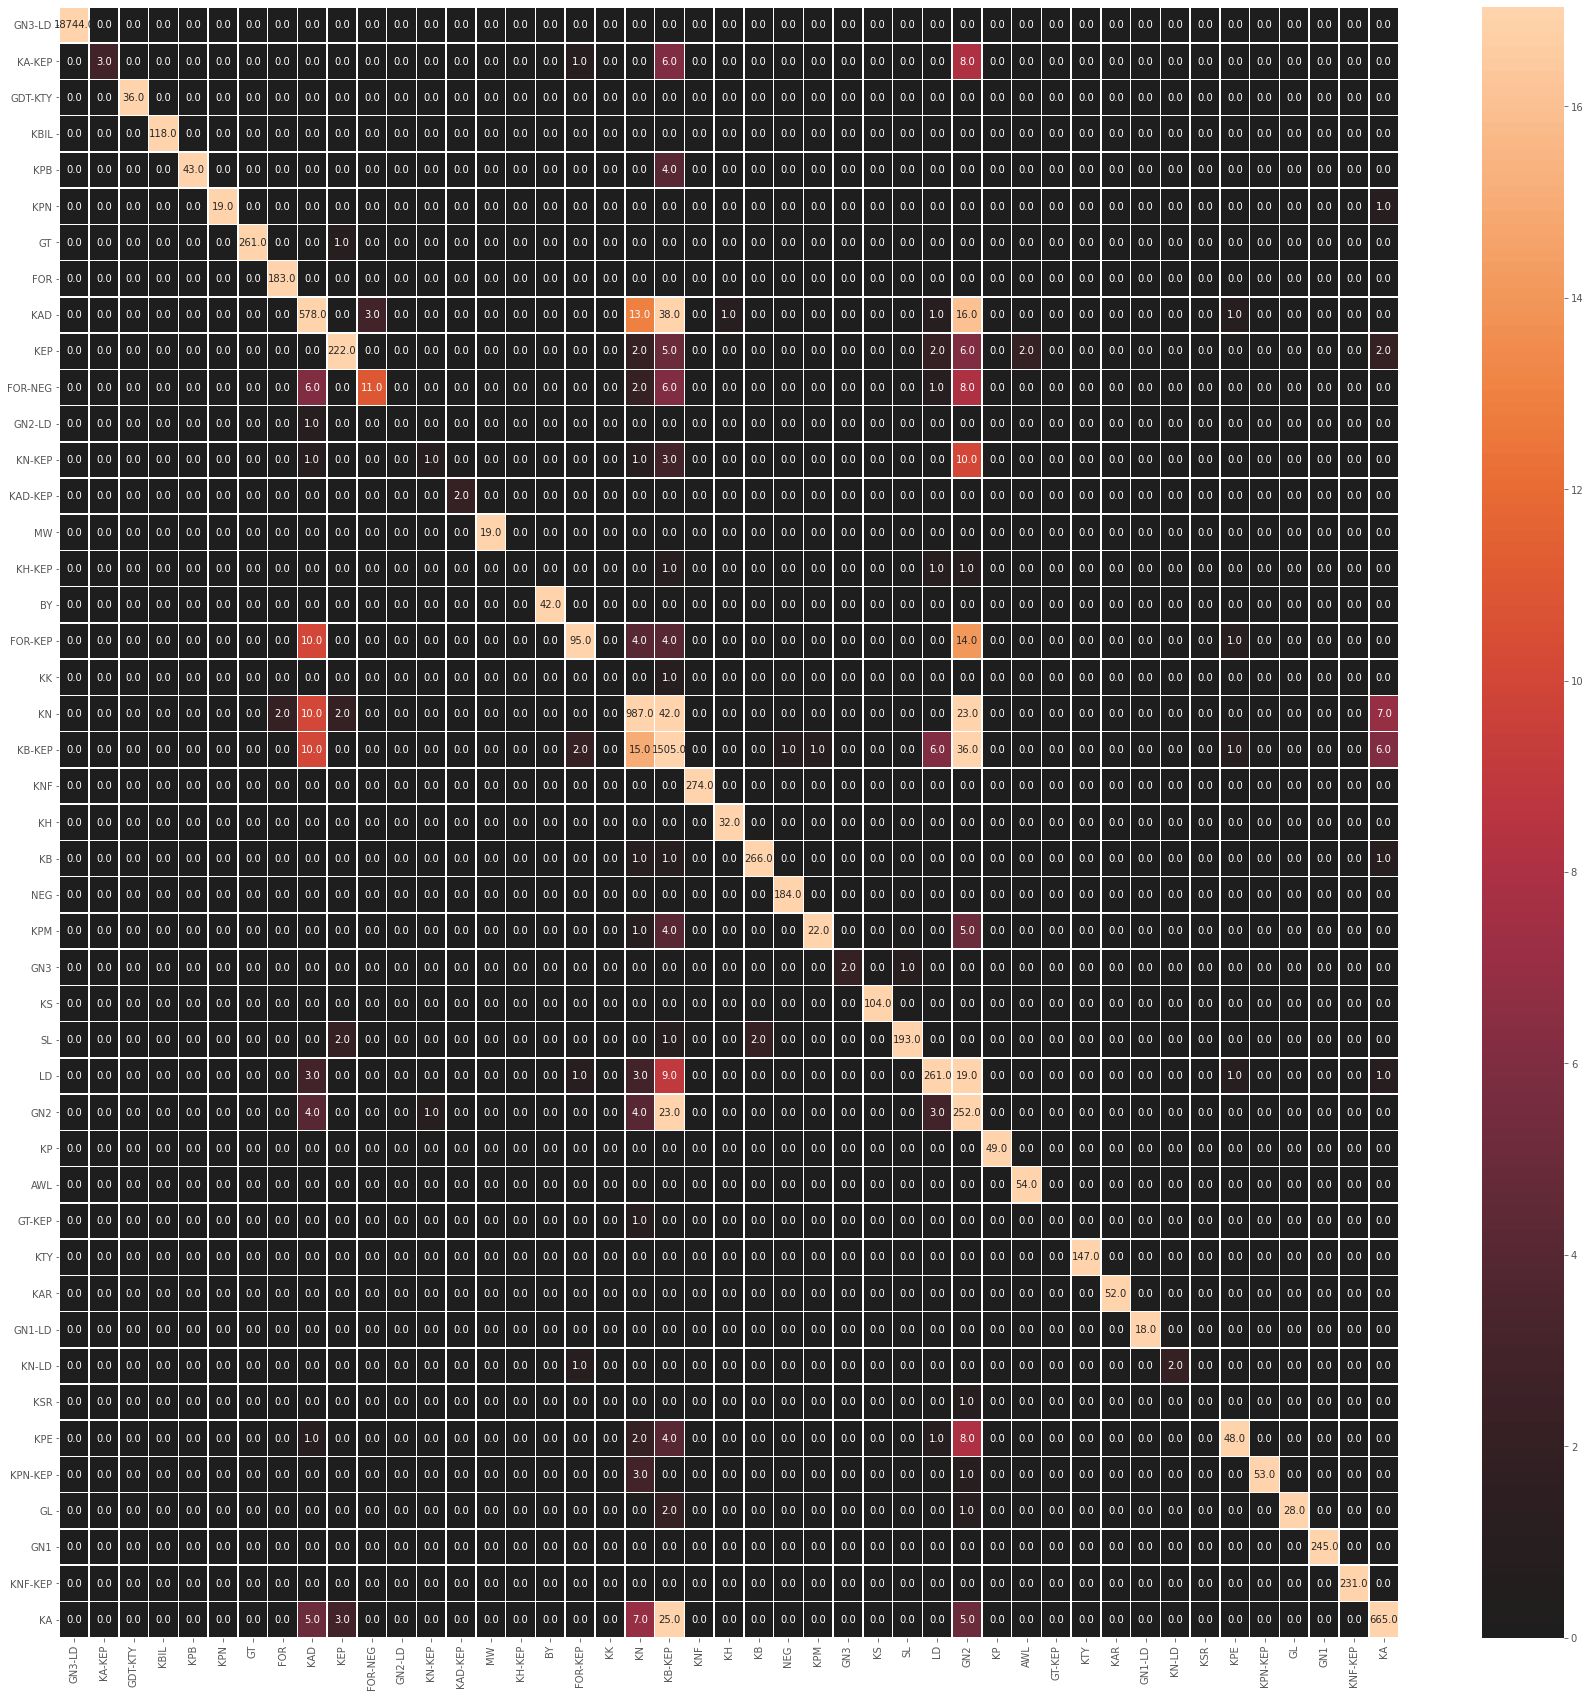

In [ ]:
f,ax = plt.subplots(figsize=(30, 30))
m=confusion_matrix(np.argmax(y_test, 2).ravel(),np.argmax(y_pred, axis=2).ravel())
sns.heatmap(cm,annot=True, fmt= '.1f',ax=ax,center=0,robust=True,linewidths=.5,xticklabels=list(idx2tag.values()),yticklabels=list(idx2tag.values()))